# Creating a Stress Detection Tool using Data From Subreddits: EDA

In this notebook I will be performing EDA on the dataset I created in the first notebook (data wrangling).  I will be breaking down things like which subreddits the comments are coming from, how long the average comment in the dataset is, and if there are any interesting and relevant ngrams within each category (stress, no stress) of the dataset.

#### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

import re

import nltk
from nltk.util import ngrams
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk import FreqDist
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer

import pickle

#### Import dataframe from pickle

In [2]:
df = pd.read_pickle('df.pickle')

#### Review dataframe to make sure everything looks right
* .head and .tail
* .shape

In [3]:
df.head(5)

,subreddit,text,text_preproc,label,stress_label
0,happy,Welcome to /r/happy where we support people in...,welcome to rhappy where we support people in t...,0,no stress
1,happy,"You are good people, Mike.",you are good people mike,0,no stress
2,happy,"Wanna come to Knight Lake near Waupaca, Wiscon...",wanna come to knight lake near waupaca wiscons...,0,no stress
3,happy,"“But, I thought the old lady dropped it into t...",“but i thought the old lady dropped it into th...,0,no stress
4,happy,Yay! Thank you for being kind and returning it!,yay thank you for being kind and returning it,0,no stress


In [4]:
df.tail(5)

,subreddit,text,text_preproc,label,stress_label
5136,relationships,"* Her, a week ago: Precious, how are you? (I i...",her a week ago precious how are you i ignored...,0,no stress
5137,ptsd,I don't have the ability to cope with it anymo...,i dont have the ability to cope with it anymor...,1,stress
5138,anxiety,In case this is the first time you're reading ...,in case this is the first time youre reading t...,0,no stress
5139,almosthomeless,Do you find this normal? They have a good rela...,do you find this normal they have a good relat...,0,no stress
5140,ptsd,I was talking to my mom this morning and she s...,i was talking to my mom this morning and she s...,1,stress


In [5]:
df.shape

(5141, 5)

#### Count occurences of each subreddit

In [6]:
df['subreddit'].value_counts()

happy               1217
ptsd                 711
relationships        694
anxiety              650
domesticviolence     388
goodnews             371
assistance           355
survivorsofabuse     315
homeless             220
almosthomeless        99
stress                78
food_pantry           43
Name: subreddit, dtype: int64

#### Subreddits Pie Chart:
* Here we can see the breakdown of which subreddits the comments came from
* Although we called an equal number of 'top posts' from each of these subreddits, each subreddit may have had a different number of top posts and/or number of comments per top post, leading to the discrepencies

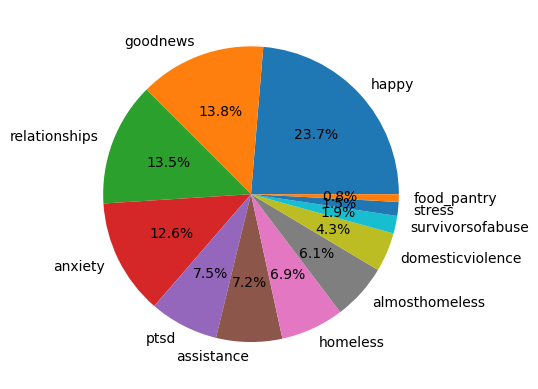

In [7]:
plt.pie(df['subreddit'].value_counts(), labels=df['subreddit'].unique().tolist(), autopct='%1.1f%%')
plt.show()

#### Look at average comment length
* Here we'll look at the min, max, and average length of comments
* Using a histogram we can see that very few comments go above 1000 characters

In [8]:
print('Min length: {}'.format(min(df['text_preproc'].str.len())))
print('Max length: {}'.format(max(df['text_preproc'].str.len())))
print('Average Length :  {}'.format(df['text_preproc'].str.len().mean()))

Min length: 1
Max length: 6262
Average Length :  349.50651624197627


<AxesSubplot: >

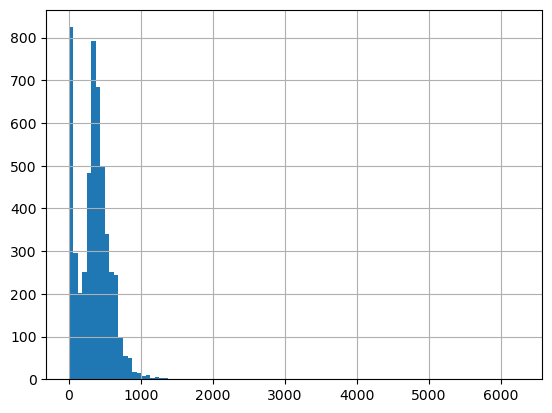

In [9]:
df['text_preproc'].str.len().hist(bins=100)

#### Finding most used words, bigrams, trigrams
* First I am splitting the datasets into 'stress' and 'no stress'
* I am then making a corpus by iterating through the preprocessed column of the dataframe

In [10]:
df_stress = df[df["stress_label"] == 'stress']
df_nostress = df[df["stress_label"] == 'no stress']

In [11]:
s_corpus = {}
s_corpus_string = ''
for t in df_stress:
    s_corpus[t]= ' '.join(df_stress['text_preproc'].tolist())
s_corpus = list(s_corpus.values())
for x in s_corpus:
    s_corpus_string += x
    
s_corpus_string = re.sub(r'[^\w\s]', '', s_corpus_string)

In [12]:
n_corpus = {}
n_corpus_string = ''
for t in df_nostress:
    n_corpus[t]= ' '.join(df_nostress['text_preproc'].tolist())
n_corpus = list(n_corpus.values())
for x in n_corpus:
    n_corpus_string += x
    
n_corpus_string = re.sub(r'[^\w\s]', '', n_corpus_string)

#### Removing stopwords
* First I am reviewing the default stopwords and then adding some more that are specific to my data

In [13]:
stopwords = stopwords.words('english')
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [14]:
stop_list = ['moderator', 'bot', 'moderators', 'bots', 'contact', 'join', 'subreddit', 'discord', 'automatically', 'invite', 'link']
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(stop_list)

In [15]:
s_corpus_string = ' '.join([word for word in s_corpus_string.split() if word not in stpwrd])

In [16]:
n_corpus_string = ' '.join([word for word in n_corpus_string.split() if word not in stpwrd])

#### Computing frequency and sorting values
* First I am creating a function that tokenizes the corpus and finds the ngrams using nltk

In [17]:
def compute_freq(sentence, n_value):

    tokens = nltk.word_tokenize(sentence)
    ngrams = nltk.ngrams(tokens, n_value)
    ngram_fdist = nltk.FreqDist(ngrams)
    return ngram_fdist

* This second function orders the ngrams by count in descending order (most commonly occuring ngrams will be at the top)

In [18]:
def sort_freq(value):
    value = sorted(freq_dist.items(), key=lambda x:x[1], reverse=True)
    value = dict(value)
    freq_df = pd.DataFrame.from_dict(value, orient='index')
    freq_df = freq_df.reset_index()
    freq_df.columns = ['ngram', 'count']
    return freq_df

* The last step is to normalize the ngram count values to make up for the imbalance between total counts for stress and no stress comments

In [19]:
def normalize_freq(value):
    cols_to_norm = ['count']
    sorted_freq[cols_to_norm] = sorted_freq[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    return value

In [20]:
freq_dist = compute_freq(s_corpus_string, 2)

sorted_freq = sort_freq(freq_dist)

stress_bigrams = normalize_freq(sorted_freq)

In [21]:
freq_dist = compute_freq(n_corpus_string, 2)

sorted_freq = sort_freq(freq_dist)

nostress_bigrams = normalize_freq(sorted_freq)

In [22]:
freq_dist = compute_freq(s_corpus_string, 3)

sorted_freq = sort_freq(freq_dist)

stress_trigrams = normalize_freq(sorted_freq)

In [23]:
freq_dist = compute_freq(n_corpus_string, 3)

sorted_freq = sort_freq(freq_dist)

nostress_trigrams = normalize_freq(sorted_freq)

#### Here I am merging the datasets in order to compare counts of the same ngram between stress and no stress categories
* The dataframe below is ordered by the stress column
* It can be seen that some bigrams are fairly equal across the categories (ex. 'dont know' and 'dont want'), while others are more unique towards one or the other
* Because this dataframe is ordered by the stress column, it can be seen that 'feel like' also occurs somewhat frequently in 'no stress', but much more frequently in 'stress'
* While occuring less frequently, other bigrams stick out such as 'panic attack(s)' and 'im trying'

In [24]:
stress_bigrams.columns = ['bigram', 'normalized count (stress)']
nostress_bigrams.columns = ['bigram', 'normalized count (no stress)']

bigrams = pd.merge(stress_bigrams, nostress_bigrams, how='outer')

bigrams.head(20)

,bigram,normalized count (stress),normalized count (no stress)
0,"(feel, like)",1.000000,0.437120
1,"(dont, know)",0.851251,0.817444
2,"(dont, want)",0.337390,0.305274
3,"(like, im)",0.273158,0.117647
4,"(can, not)",0.208925,0.097363
5,"(im, going)",0.188641,0.153144
6,"(even, though)",0.178499,0.168357
7,"(im, scared)",0.178499,0.006085
8,"(panic, attacks)",0.171738,0.046653
9,"(anyone, else)",0.168357,0.137931


* Now I am reordering the dataset by the 'no stress' column
* It can be seen pretty easily here that there is some junk that was not easily filtered out by the stopwords
* Despite that, some useful information can still be seen
* 'Dont know' occurs fairly evenly across categories while 'dont give' and 'say anything' are more unique to 'no stress'

In [25]:
bigrams_reorder = bigrams.sort_values(by = ['normalized count (no stress)'], ascending = False)
bigrams_reorder = bigrams_reorder.reset_index(drop=True)

bigrams_reorder.head(20)

,bigram,normalized count (stress),normalized count (no stress)
0,"(action, performed)",NaN,1.000000
1,"(performed, please)",NaN,1.000000
2,"(questions, concerns)",NaN,1.000000
3,"(dont, know)",0.851251,0.817444
4,"(youre, welcome)",NaN,0.563895
5,"(dont, feel)",0.117647,0.548682
6,"(even, dont)",0.009466,0.528398
7,"(dont, give)",0.006085,0.523327
8,"(know, dont)",0.029750,0.523327
9,"(hang, around)",NaN,0.518256


* Below I am repeating the same steps for trigrams
* Many of the trigrams seen in 'stress' are very uncommon to 'no stress' such as 'feel like shit', 'dont really know' and 'feel like im'

In [26]:
stress_trigrams.columns = ['trigram', 'normalized count (stress)']
nostress_trigrams.columns = ['trigram', 'normalized count (no stress)']

trigrams = pd.merge(stress_trigrams, nostress_trigrams, how='outer')

trigrams.head(20)

,trigram,normalized count (stress),normalized count (no stress)
0,"(feel, like, im)",1.000000,0.051724
1,"(dont, even, know)",0.507299,0.016227
2,"(dont, feel, like)",0.288321,0.021298
3,"(dont, know, feel)",0.270073,0.006085
4,"(dont, know, anymore)",0.270073,NaN
5,"(dont, really, know)",0.251825,0.016227
6,"(long, story, short)",0.215328,0.031440
7,"(dont, know, im)",0.215328,0.011156
8,"(know, feel, like)",0.197080,NaN
9,"(feel, like, cant)",0.178832,0.001014


* And as expected, the trigrams in 'no stress' contain even more junk, however there are the trigrams 'dont know dont' and 'cant think anything' that seem legitimate and obviously more common in 'no stress'

In [27]:
trigrams_reorder = trigrams.sort_values(by = ['normalized count (no stress)'], ascending = False)
trigrams_reorder = trigrams_reorder.reset_index(drop=True)

trigrams_reorder.head(20)

,trigram,normalized count (stress),normalized count (no stress)
0,"(action, performed, please)",NaN,1.000000
1,"(server, httpsdiscordggum5b3jm, action)",NaN,0.503043
2,"(httpsdiscordggum5b3jm, action, performed)",NaN,0.503043
3,"(subredditmessagecomposetorgoodnews, questions...",NaN,0.503043
4,"(please, subredditmessagecomposetorgoodnews, q...",NaN,0.503043
5,"(performed, please, subredditmessagecomposetor...",NaN,0.503043
6,"(thanks, contributing, rgoodnews)",NaN,0.503043
7,"(contributing, rgoodnews, enjoy)",NaN,0.503043
8,"(rgoodnews, enjoy, come)",NaN,0.503043
9,"(enjoy, come, us)",NaN,0.503043


#### Visualizing bigrams

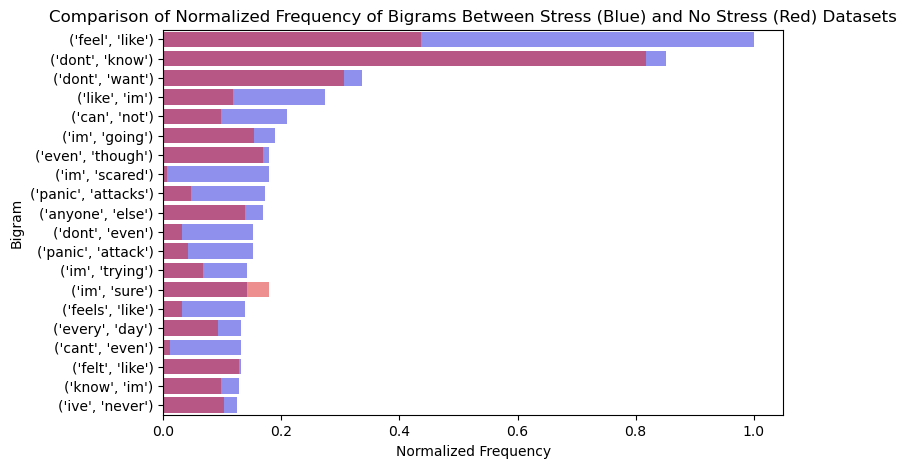

In [28]:
bigrams20 = bigrams.head(20)

fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.barplot(y='bigram', 
            x='normalized count (stress)', 
            data=bigrams20,
            alpha=0.5,
            color='blue',
            ax=ax)

ax = sns.barplot(y='bigram', 
            x='normalized count (no stress)', 
            data=bigrams20, 
            alpha=0.5,
            color='red',
            ax=ax)

ax.set(xlabel="Normalized Frequency", ylabel="Bigram", title='Comparison of Normalized Frequency of Bigrams Between Stress (Blue) and No Stress (Red) Datasets')

plt.show()

#### Visualizing trigrams

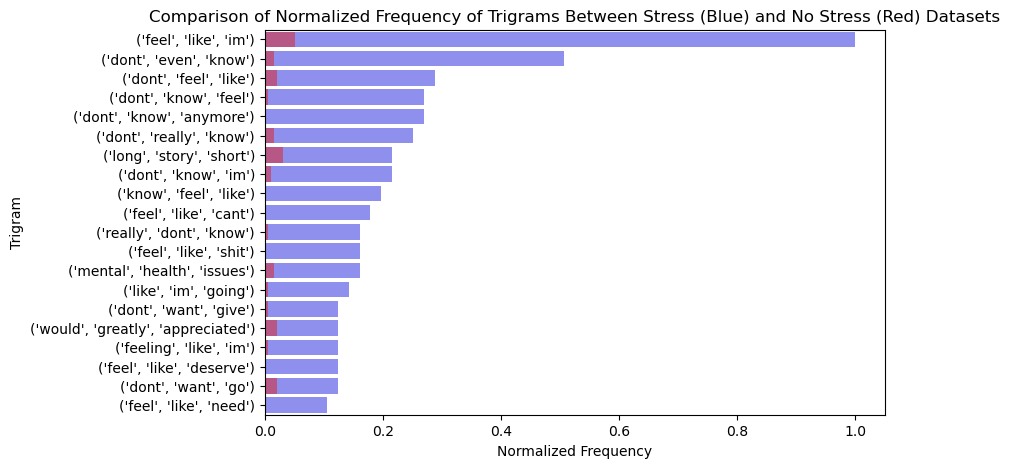

In [29]:
trigrams20 = trigrams.head(20)

fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.barplot(y='trigram', 
            x='normalized count (stress)', 
            data=trigrams20,
            alpha=0.5,
            color='blue',
            ax=ax)

ax = sns.barplot(y='trigram', 
            x='normalized count (no stress)', 
            data=trigrams20, 
            alpha=0.5,
            color='red',
            ax=ax)

ax.set(xlabel="Normalized Frequency", 
       ylabel="Trigram", 
       title='Comparison of Normalized Frequency of Trigrams Between Stress (Blue) and No Stress (Red) Datasets')

plt.show()